# 5. User groups

## 1. Import Required Libraries and load data

In [194]:
%config InlineBackend.figure_format = 'retina'

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, Markdown
from itertools import combinations
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest
from utils import setup_pandas, setup_plotting


# --- global notebook setup (pandas + tueplots/matplotlib style) ---
setup_pandas()
setup_plotting()


# --- project paths ---
PROCESSED_DATA_PATH = Path('../dat/processed')
CLEANED_FILE = PROCESSED_DATA_PATH / "borrowings_2019_2025_cleaned.csv"


In [195]:
# --- load data ---

borrowings = pd.read_csv(
    CLEANED_FILE,
    sep=";",
    quotechar='"',
    encoding="utf-8"
)

print("Loaded shape:", borrowings.shape)

Loaded shape: (2313072, 21)


In [196]:
# ---- processing relevant columns ----
ISSUE_COL = "Ausleihdatum/Uhrzeit"
DURATION_COL = "Leihdauer"
EXT_COL = "Anzahl_Verlängerungen"
LATE_FLAG_COL = "Verspätet"
MEDIA_TYPE_COL = "Medientyp"
USER_TYPE_COL = "Benutzerkategorie"
CCODE_COL = "Sammlungszeichen/CCODE"

In [197]:
borrowings[ISSUE_COL] = pd.to_datetime(borrowings[ISSUE_COL], errors="coerce")
borrowings[DURATION_COL] = pd.to_numeric(borrowings[DURATION_COL], errors="coerce")

v = borrowings[LATE_FLAG_COL].astype(str).str.strip().str.lower()
borrowings["late_bool"] = pd.Series(np.where(v == "ja", True, np.where(v == "nein", False, pd.NA)), dtype="boolean")

borrowings["issue_month"] = borrowings[ISSUE_COL].dt.month
borrowings["issue_weekday"] = borrowings[ISSUE_COL].dt.weekday
season_map = {12: "winter", 1: "winter", 2: "winter", 3: "spring", 4: "spring", 5: "spring", 6: "summer", 7: "summer", 8: "summer", 9: "fall", 10: "fall", 11: "fall"}
borrowings["issue_season"] = borrowings["issue_month"].map(season_map)

base_rate = borrowings["late_bool"].mean()
print(f"Grundwahrscheinlichkeit für Verspätungen: {base_rate:.2%}")

Grundwahrscheinlichkeit für Verspätungen: 4.17%


## 2. Display Late rate for each User Group

/tmp/ipykernel_60595/3084502503.py:15: UserWarning:

The figure layout has changed to tight



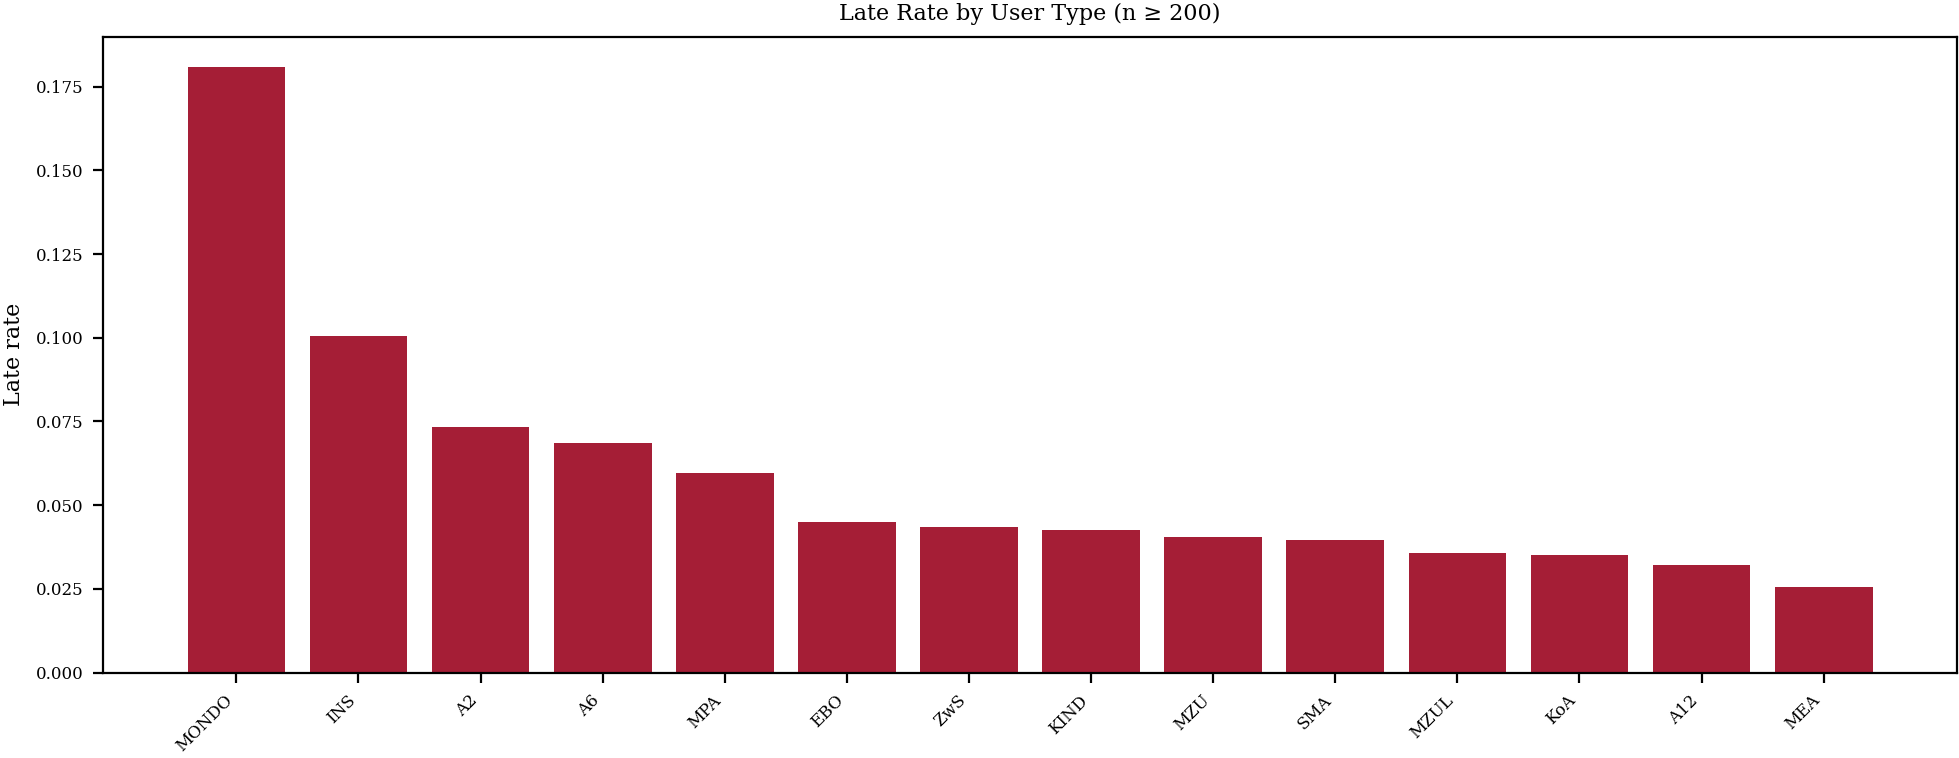

In [198]:
USER_CATEGORY_late = (
    borrowings.groupby(USER_TYPE_COL)["late_bool"]
    .agg(["mean","count"])
    .sort_values(by="mean", ascending=False)
)

USER_CATEGORY_late

plot_df = USER_CATEGORY_late[USER_CATEGORY_late["count"] >= 200]
plt.figure(figsize=(10, 4))
plt.bar(plot_df.index.astype(str), plot_df["mean"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Late rate")
plt.title("Late Rate by User Type (n ≥ 200)")
plt.tight_layout()
plt.show()

# 3. bla bla

/tmp/ipykernel_60595/1866000935.py:51: UserWarning:

The figure layout has changed to tight



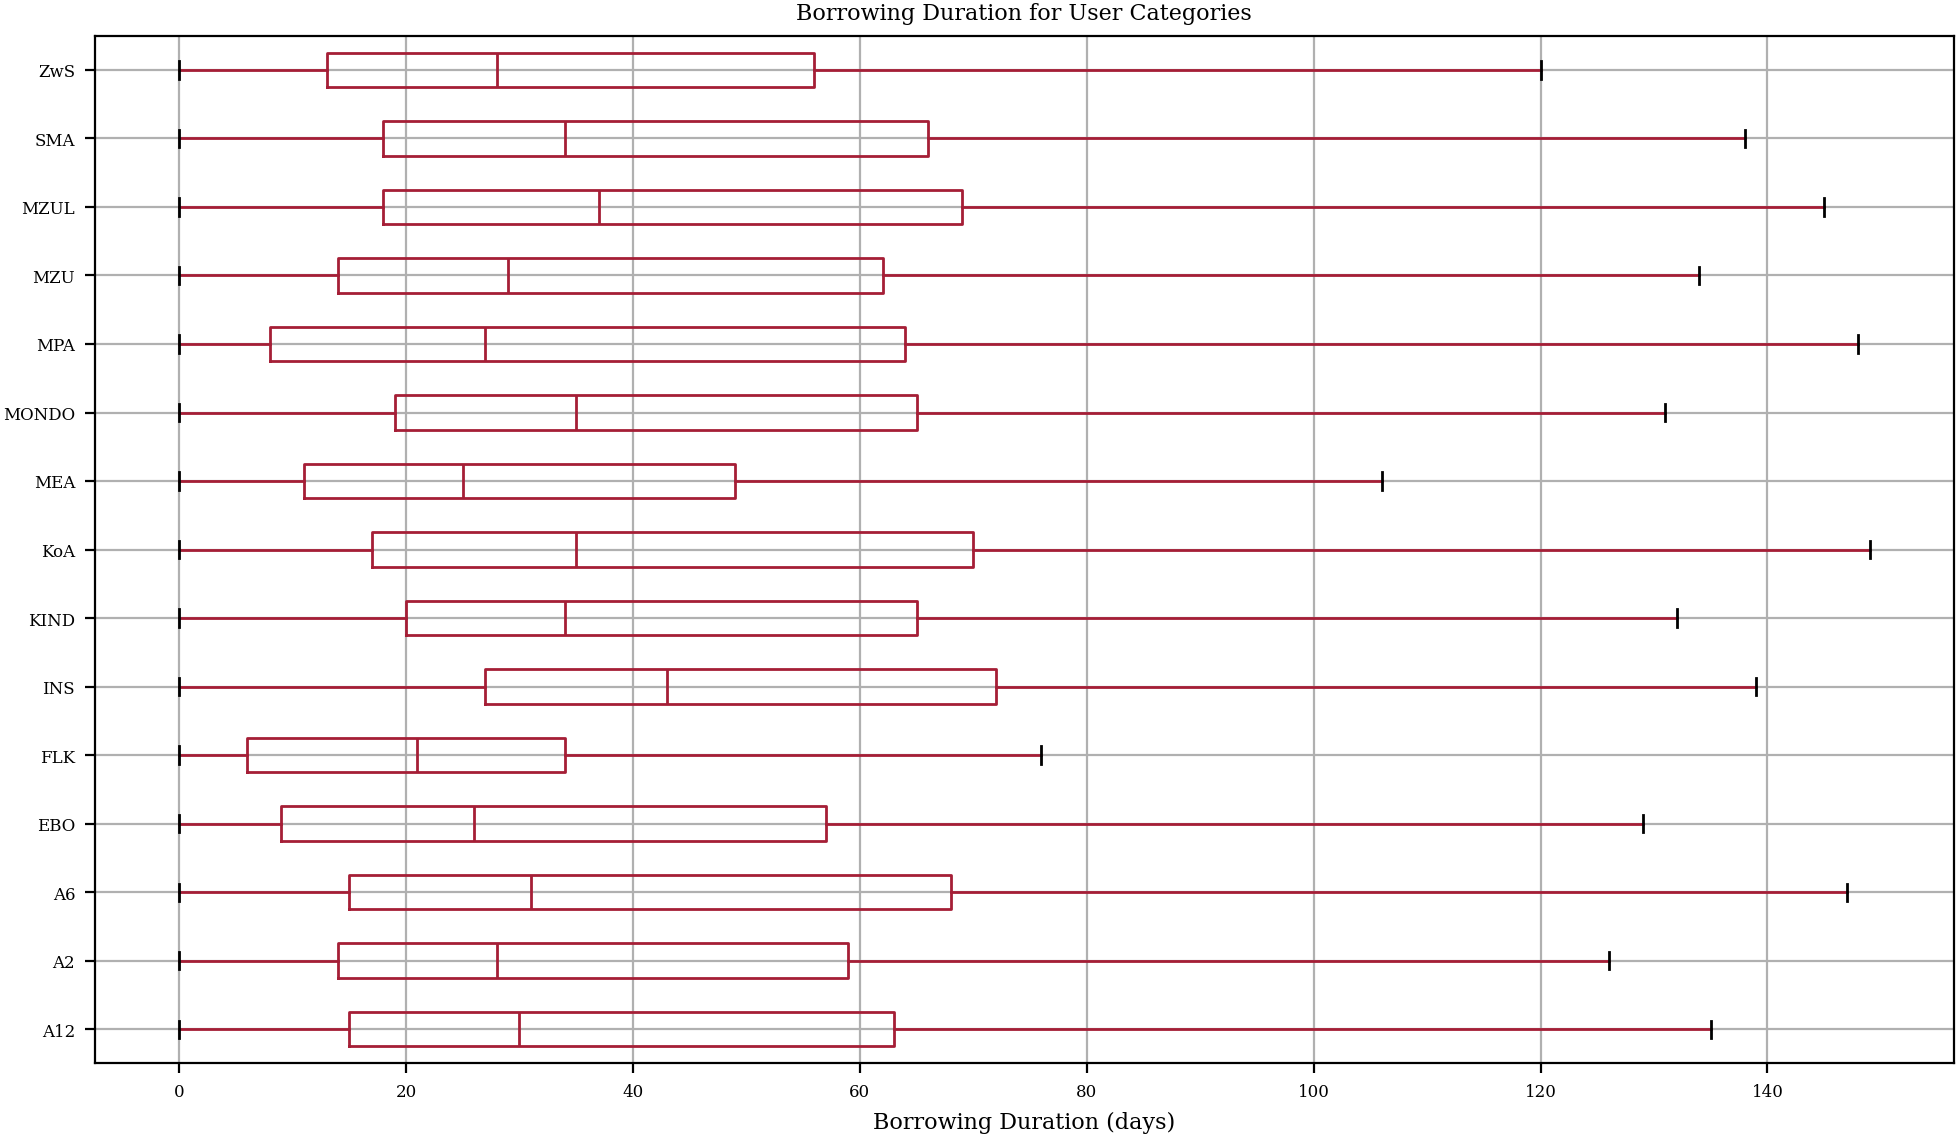

,Benutzerkategorie,mean,median,p75,p90,p95,late_rate_percent,median_late,median_on_time
9,MONDO,55.2403,35.0000,65.0000,144.8000,198.0000,18.0879,65.0000,27.0000
5,INS,57.3478,43.0000,72.0000,119.0000,160.0000,10.0442,57.0000,42.0000
1,A2,46.4375,28.0000,59.0000,112.0000,160.0000,7.3402,74.0000,27.0000
2,A6,52.8440,31.0000,68.0000,131.0000,177.0000,6.8652,70.0000,29.0000
10,MPA,49.5131,27.0000,64.0000,130.0000,182.0000,5.9650,71.0000,25.0000
3,EBO,45.1132,26.0000,57.0000,114.0000,168.0000,4.4966,68.0000,24.0000
4,FLK,24.6522,21.0000,34.0000,54.0000,67.2000,4.3478,63.0000,20.0000
14,ZwS,42.8575,28.0000,56.0000,98.0000,137.0000,4.3389,42.0000,27.0000
6,KIND,51.2139,34.0000,65.0000,115.0000,160.0000,4.2544,55.0000,33.0000
11,MZU,48.8939,29.0000,62.0000,118.0000,170.0000,4.0434,56.0000,28.0000


In [199]:
leihdauer_stats = (
    borrowings.groupby("Benutzerkategorie")["Leihdauer"].agg(
        mean="mean",
        median="median",
        p75=lambda x: x.quantile(0.75),
        p90=lambda x: x.quantile(0.90),
        p95=lambda x: x.quantile(0.95),
    )
    .reset_index()
)

late_rate = (
    borrowings
    .groupby("Benutzerkategorie")["Verspätet"]
    .apply(lambda x: (x == "Ja").mean() * 100)
    .rename("late_rate_percent")
)

leihdauer_by_late = (
    borrowings
    .groupby(["Benutzerkategorie", "Verspätet"])["Leihdauer"]
    .median()
    .unstack()
    .rename(columns={"Ja": "median_late", "Nein": "median_on_time"})
)


final_table = (
    leihdauer_stats
    .set_index("Benutzerkategorie")
    .join(late_rate)
    .join(leihdauer_by_late)
    .reset_index()
    .sort_values("late_rate_percent", ascending=False)
)

order = final_table["Benutzerkategorie"].tolist()

borrowings.boxplot(
    column="Leihdauer",
    by="Benutzerkategorie",
    vert=False,
    grid=True,
    showfliers=False,
    figsize=(10, 6)
)
plt.suptitle("")
plt.title("Borrowing Duration for User Categories")
plt.xlabel("Borrowing Duration (days)")
plt.ylabel("")
plt.tight_layout()
plt.show()

display(final_table)

#  4. Borrowing volume per User Group

/tmp/ipykernel_60595/589887429.py:35: UserWarning:

The figure layout has changed to tight



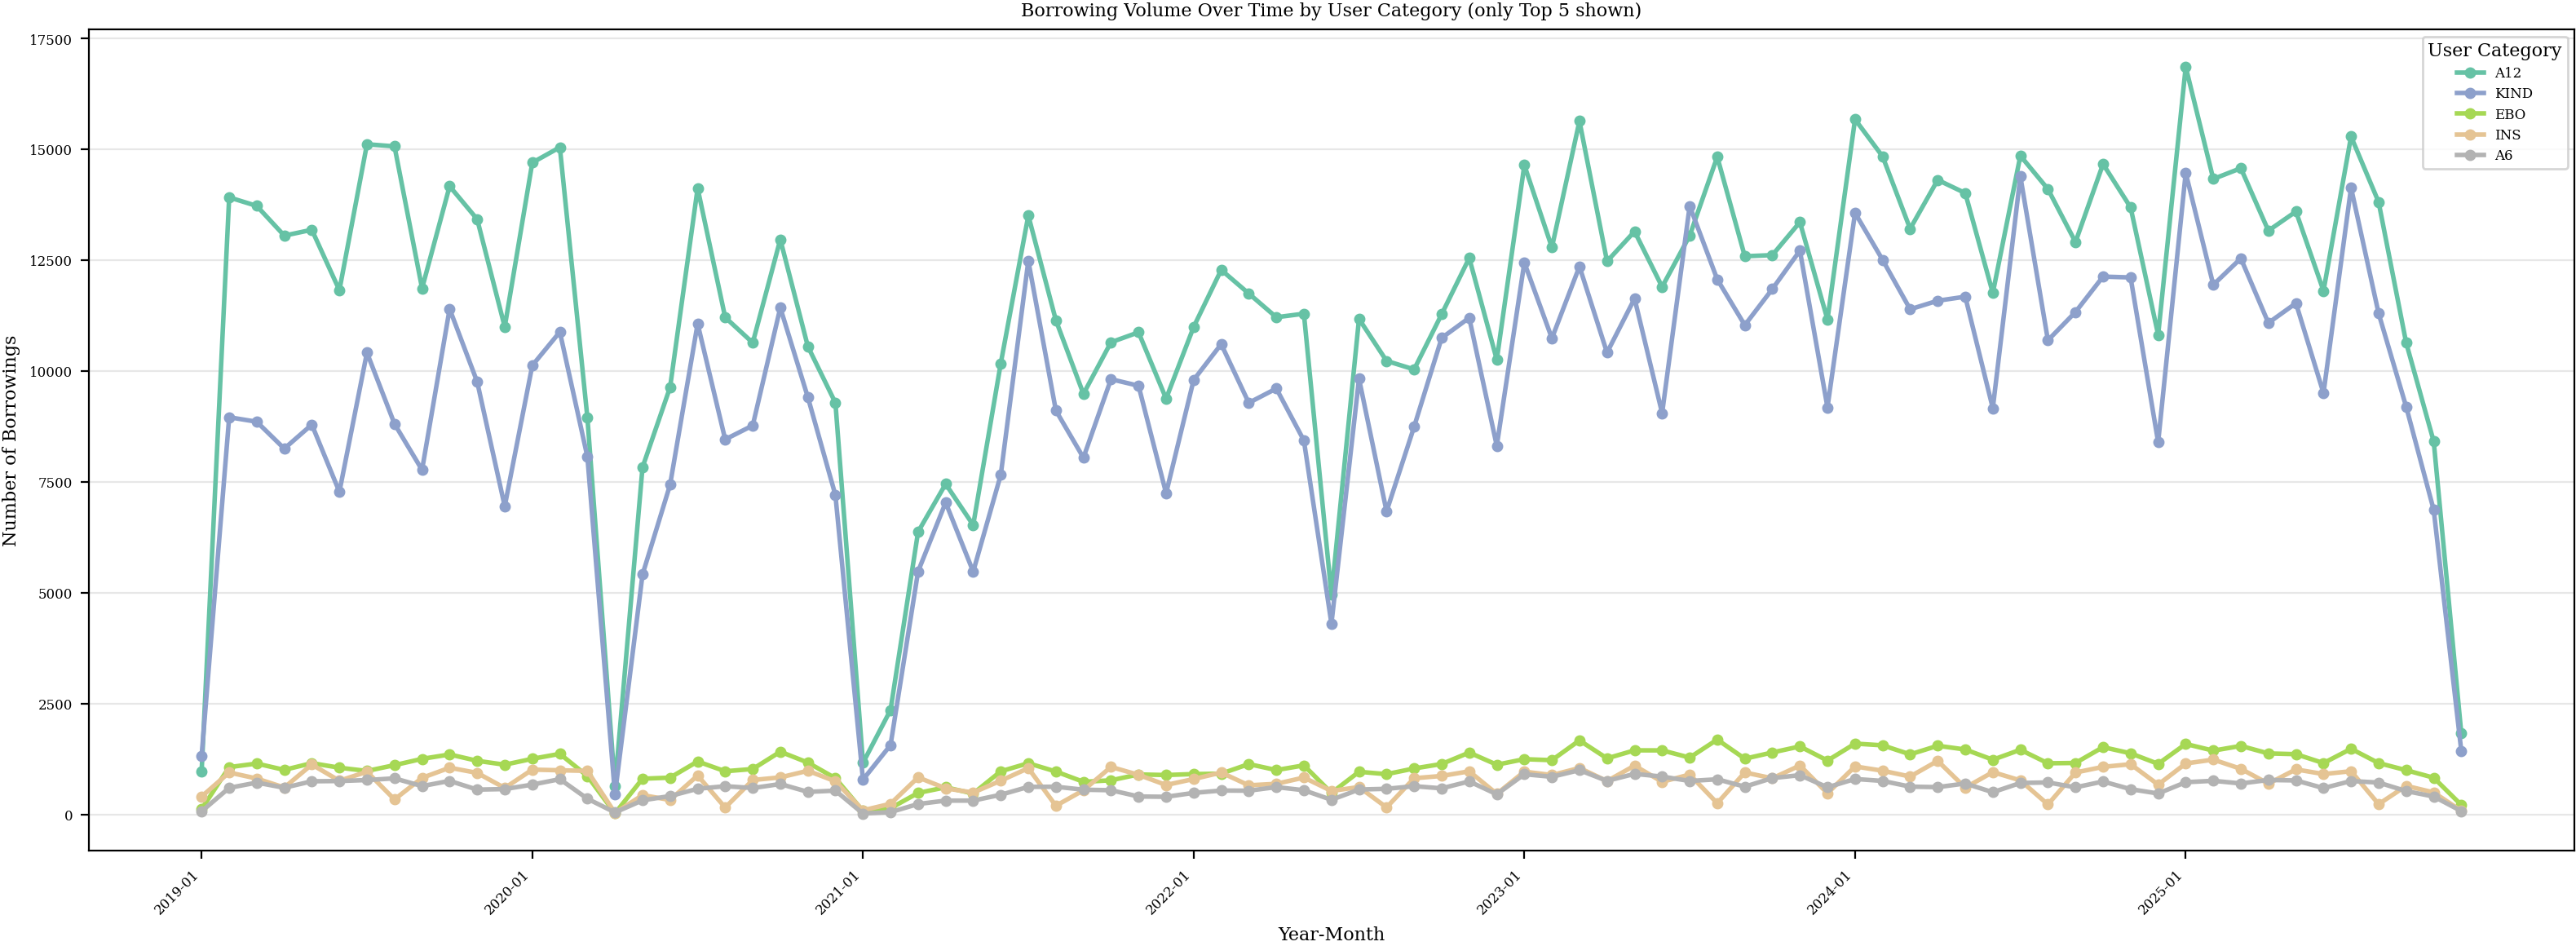

In [200]:
borrowings["issue_year_month"] = borrowings[ISSUE_COL].dt.to_period("M")

monthly_by_user = (
    borrowings[borrowings[USER_TYPE_COL].isin(order)]
    .groupby(["issue_year_month", USER_TYPE_COL])
    .size()
    .unstack(fill_value=0)
)

top_users = borrowings[USER_TYPE_COL].value_counts().head(5).index.tolist()

colors = plt.cm.Set2(np.linspace(0, 1, len(top_users[:5])))

plt.figure(figsize=(16, 6))
for idx, user in enumerate(top_users[:5]):
    if user in monthly_by_user.columns:
        plt.plot(monthly_by_user.index.astype(str), monthly_by_user[user],
                marker="o", label=user, markersize=4, linewidth=2, color=colors[idx])

x_labels = monthly_by_user.index.astype(str)
tick_positions = range(0, len(x_labels), 12)  # Alle 12 Monate (1 Jahr)
tick_labels = [x_labels[i] for i in tick_positions if i < len(x_labels)]

plt.xticks(tick_positions, tick_labels, rotation=45, ha="right")
plt.xlabel("Year-Month")
plt.ylabel("Number of Borrowings")
plt.title("Borrowing Volume Over Time by User Category (only Top 5 shown)")
plt.legend(title="User Category", loc="best")
plt.grid(alpha=0.3, axis="y")
plt.tight_layout()
plt.show()

## 5. Calculate Marginal Late Rates by Feature

In [201]:
def conditional_rate(col: str, min_count: int = 30) -> pd.DataFrame:
    tbl = (
        borrowings.groupby(col)["late_bool"]
        .agg(mean_rate="mean", n="count")
        .sort_values("mean_rate", ascending=False)
    )
    return tbl[tbl["n"] >= min_count]

user_rate = conditional_rate(USER_TYPE_COL)
media_rate = conditional_rate(MEDIA_TYPE_COL)
ccode_rate = conditional_rate(CCODE_COL)
season_rate = conditional_rate("issue_season")
month_rate = conditional_rate("issue_month")
weekday_rate = conditional_rate("issue_weekday")

## 6. Interactive Feature Selector for Late Return Probability Estimation

In [202]:
def estimate_late_probability(feature_values: dict, min_count: int = 20):
    available = {k: v for k, v in feature_values.items() if v is not None}
    cols = list(available.keys())
    if not cols:
        return {"p_late": base_rate, "n": len(borrowings), "used_features": []}

    mask = pd.Series(True, index=borrowings.index)
    for c in cols:
        mask &= borrowings[c] == available[c]
    subset = borrowings[mask]

    if len(subset) >= min_count:
        return {
            "p_late": subset["late_bool"].mean(),
            "n": len(subset),
            "used_features": cols
        }
    else:
        return {"p_late": base_rate, "n": len(subset), "used_features": [], "warning": f"Nur {len(subset)} Fälle - zu wenig für stabile Schätzung"}

def _with_none(options, label="(keine Auswahl)"):
    return [(label, None)] + [(str(o), o) for o in options]

user_opts = _with_none(sorted(borrowings[USER_TYPE_COL].dropna().unique()))
media_opts = _with_none(sorted(borrowings[MEDIA_TYPE_COL].dropna().unique()))
ccode_opts = _with_none(sorted(borrowings[CCODE_COL].dropna().unique()))
season_opts = _with_none(["winter", "spring", "summer", "fall"])
weekday_opts = _with_none(list(range(0, 7)), label="(alle)")

w_user = widgets.Dropdown(options=user_opts, description="Benutzer")
w_media = widgets.Dropdown(options=media_opts, description="Medientyp")
w_ccode = widgets.Dropdown(options=ccode_opts, description="CCODE")
w_season = widgets.Dropdown(options=season_opts, description="Saison")
w_weekday = widgets.Dropdown(options=weekday_opts, description="Wochentag")

out = widgets.Output()

def _update(*_):
    feat = {
        USER_TYPE_COL: w_user.value,
        MEDIA_TYPE_COL: w_media.value,
        CCODE_COL: w_ccode.value,
        "issue_season": w_season.value,
        "issue_weekday": w_weekday.value,
    }
    res = estimate_late_probability(feat, min_count=20)
    with out:
        out.clear_output()

        warning = ""
        if "warning" in res:
            warning = f"<br> {res['warning']}"

        display(Markdown(
            f"**Geschätzte Verspätungsrate:** {res['p_late']:.2%}<br>"\
            f"**Verwendete Merkmale:** {', '.join(res['used_features']) if res['used_features'] else 'Basisrate (zu wenig Daten)'}<br>"\
            f"**Stichprobe:** n = {res['n']}<br>"\
            f"**Grundwahrscheinlichkeit für Verspätungen:** {base_rate:.2%}<br>"\
            f"{warning}"
        ))

for w in [w_user, w_media, w_ccode, w_season, w_weekday]:
    w.observe(_update, names="value")
display(widgets.VBox([w_user, w_media, w_ccode, w_season, w_weekday, out]))

_update()

This tool calculates **conditional probabilities** for late returns based on specific combinations of features (user type, mediatype, CCODE, saison, weekday).

**What it does:**
1. Takes the features you select (e.g., "User = Child" AND "Saison = Winter")
2. Filters the dataset to find all borrowing records that match **exactly this combination**
3. Calculates the late return rate for those specific cases
4. Shows you the result with sample size (n)

**The min_count warning:**

If fewer than 20 cases exist for your selected combination, the estimate becomes unreliable (too much random noise). In that case, the tool shows a warning and falls back to the overall baseline rate.

**What the output means:**

- **Estimated late return rate**: The percentage of borrowings in your selected combination that were returned late. This is the main result.
- **Used features**: Which features were actually used for the calculation. If you selected features but got too few cases, this shows what was used instead.
- **Sample size (n)**: How many borrowing records matched your combination. Larger n = more reliable estimate.
- **Base probability for Late retutns**: The late return rate across ALL borrowings, regardless of features. This serves as a reference point, is the given combination riskier or safer than average?

## 7. Compute Conditional Probabilities for Feature Combinations and confidence intervals

In [203]:
def wilson_ci(successes, n, z=1.96):
    """Wilson-Konfidenzintervall für Binomialraten (robuster bei kleinem n/Extremen)."""
    successes = np.asarray(successes, dtype=float)
    n = np.asarray(n, dtype=float)
    p = successes / n
    denom = 1 + (z ** 2) / n
    center = p + (z ** 2) / (2 * n)
    half = z * np.sqrt((p * (1 - p) + (z ** 2) / (4 * n)) / n)
    low = (center - half) / denom
    high = (center + half) / denom
    return np.clip(low, 0, 1), np.clip(high, 0, 1)


def combo_table(features, max_order=3, min_count=50, z=1.96):
    rows = []
    for r in range(2, max_order + 1):
        for cols in combinations(features, r):
            grp = borrowings.groupby(list(cols))["late_bool"].agg(["mean", "count"]).reset_index()
            grp = grp.rename(columns={"mean": "p_late", "count": "n"})
            grp = grp[grp["n"] >= min_count]
            if grp.empty:
                continue
            successes = grp["p_late"] * grp["n"]
            ci_low, ci_high = wilson_ci(successes, grp["n"], z=z)
            grp["ci_low"] = ci_low
            grp["ci_high"] = ci_high
            grp["features"] = [cols] * len(grp)
            rows.append(grp)
    if not rows:
        return pd.DataFrame()
    return pd.concat(rows, ignore_index=True)

feature_list = [USER_TYPE_COL, MEDIA_TYPE_COL, CCODE_COL, "issue_season", "issue_month", "issue_weekday"]
combo_df = combo_table(feature_list, max_order=3, min_count=40)

## 8. Identify High-Risk Combinations

In [204]:
weekday_labels = {0: "Mo", 1: "Di", 2: "Mi", 3: "Do", 4: "Fr", 5: "Sa", 6: "So"}

feature_cols = [
    USER_TYPE_COL,
    MEDIA_TYPE_COL,
    CCODE_COL,
    "issue_season",
    "issue_month",
    "issue_weekday",
]

def expand_features(row):
    vals = {c: None for c in feature_cols}
    for f in row["features"]:
        vals[f] = row[f]
    if vals["issue_weekday"] is not None:
        vals["issue_weekday"] = weekday_labels.get(vals["issue_weekday"], vals["issue_weekday"])
    return pd.Series(vals)

def format_label(row):
    parts = []
    for f in row["features"]:
        val = row[f]
        if f == "issue_weekday":
            val = weekday_labels.get(val, val)
        parts.append(f"{f}={val}")
    return "\n".join(parts)

top_n = 15
risk_tbl = combo_df.sort_values("p_late", ascending=False).head(top_n).copy()
wide = risk_tbl.apply(expand_features, axis=1)
view = pd.concat([risk_tbl[["p_late", "ci_low", "ci_high", "n"]].reset_index(drop=True), wide.reset_index(drop=True)], axis=1)

view = view.rename(
    columns={
        "p_late": "late_rate",
        "ci_low": "ci_low",
        "ci_high": "ci_high",
        "n": "n",
        USER_TYPE_COL: "Benutzer",
        MEDIA_TYPE_COL: "Medientyp",
        CCODE_COL: "CCODE",
        "issue_season": "Saison",
        "issue_month": "Monat",
        "issue_weekday": "Wochentag",
    }
)

fmt = {"late_rate": "{:.2%}".format, "ci_low": "{:.2%}".format, "ci_high": "{:.2%}".format}
display(view.style.format(fmt).set_properties(**{"text-align": "left"}))

,late_rate,ci_low,ci_high,n,Benutzer,Medientyp,CCODE,Saison,Monat,Wochentag
0,72.73%,61.88%,81.42%,77,INS,None,jufr,None,7.000000,None
1,70.00%,59.23%,78.94%,80,INS,None,jufr,summer,nan,None
2,67.47%,56.81%,76.58%,83,INS,None,jufr,None,nan,Mi
3,52.27%,37.94%,66.25%,44,INS,None,dvdkisa,spring,nan,None
4,51.75%,42.67%,60.72%,114,None,None,jufr,None,7.000000,Mi
5,50.00%,36.64%,63.36%,50,ZwS,None,dvdki,None,9.000000,None
6,49.06%,36.12%,62.12%,53,EBO,None,esaw,None,9.000000,None
7,41.86%,28.38%,56.67%,43,MONDO,None,None,summer,8.000000,None
8,41.86%,28.38%,56.67%,43,MONDO,None,None,None,8.000000,None
9,37.93%,26.56%,50.80%,58,INS,None,kisare,None,2.000000,None


## 9. Interaction Effects: User Groups × Media Types

Do user groups behave differently depending on the media type? For example, children might be punctual with books but late with DVDs.

This analysis reveals interaction effects where the impact of one feature (user group) depends on another feature (media type).

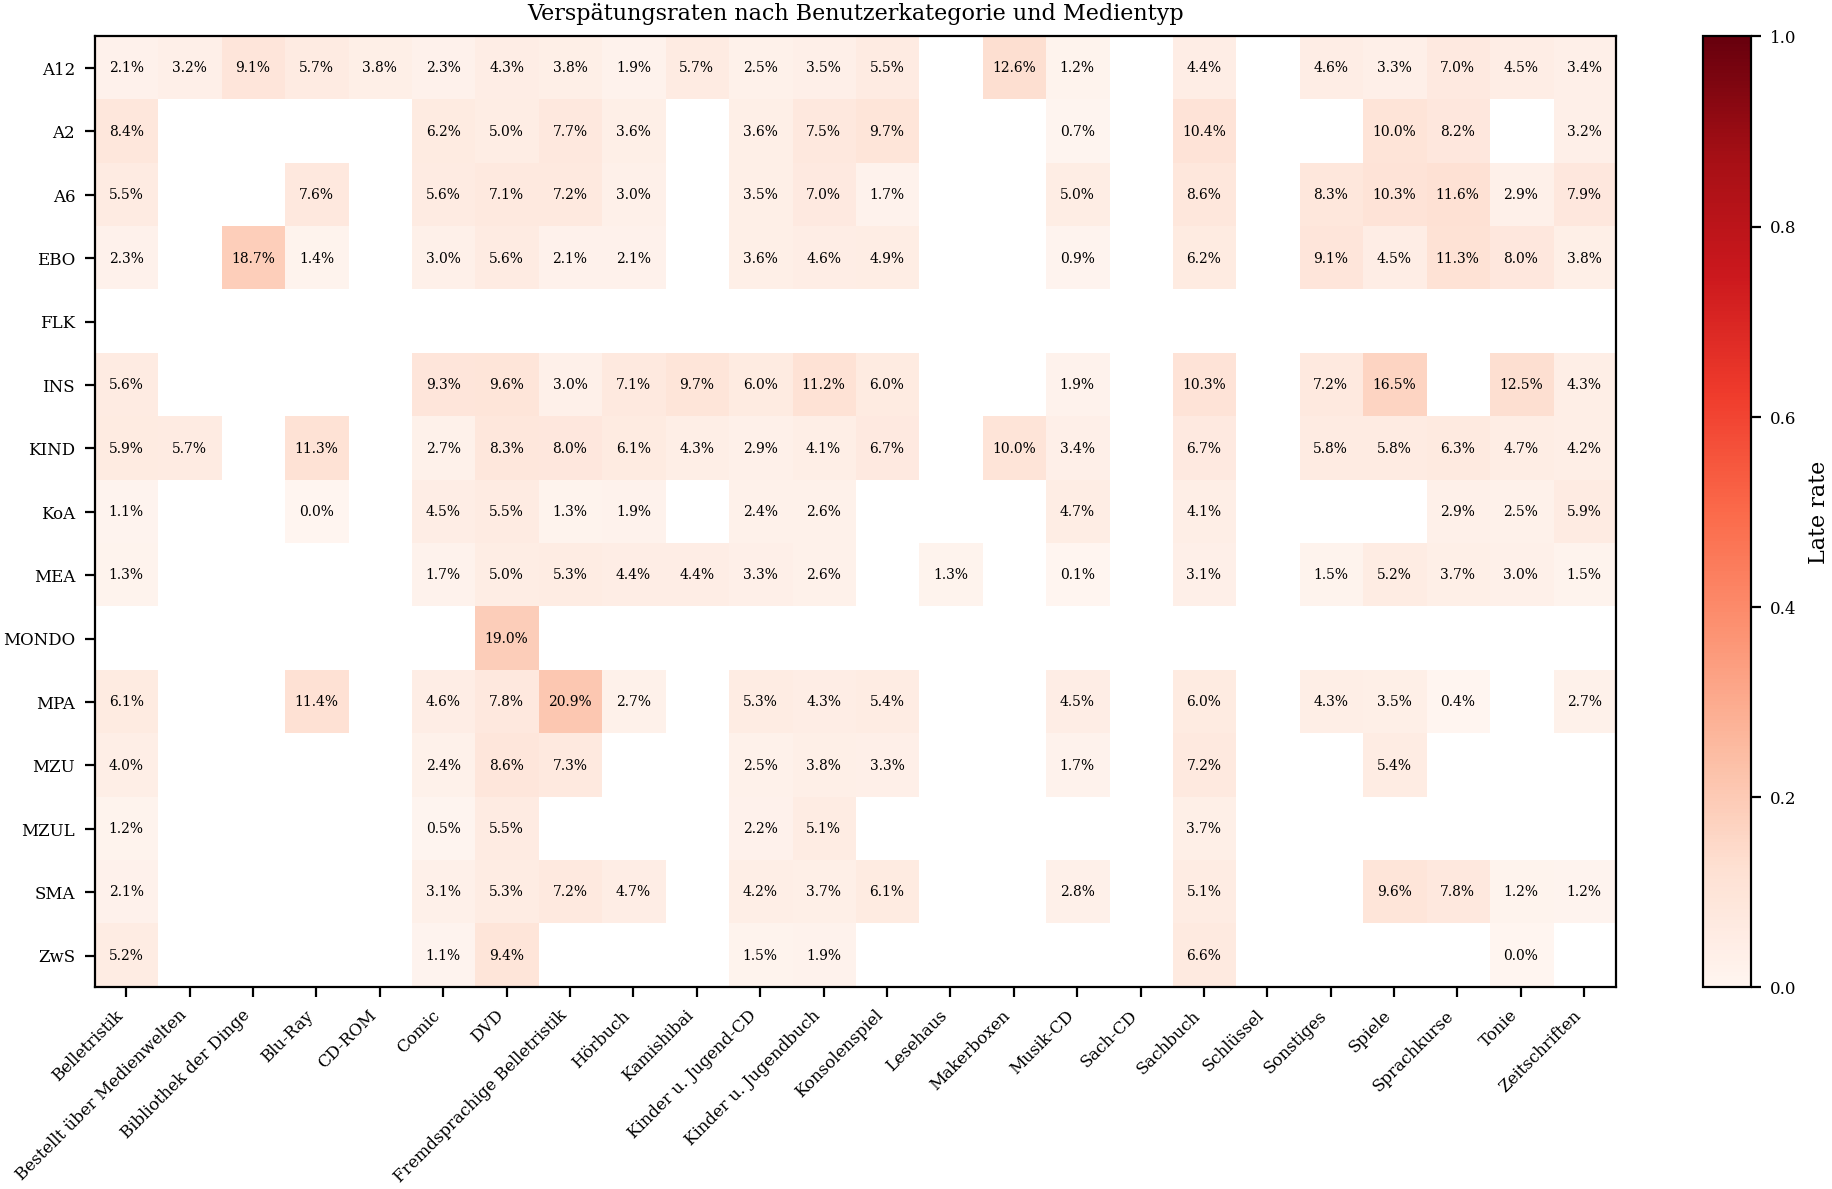

In [205]:
min_count_heatmap = 100
heat = (
    borrowings.groupby([USER_TYPE_COL, MEDIA_TYPE_COL])["late_bool"]
    .agg(p_late="mean", n="count")
    .reset_index()
)
heat.loc[heat["n"] < min_count_heatmap, "p_late"] = np.nan
pivot = heat.pivot(index=USER_TYPE_COL, columns=MEDIA_TYPE_COL, values="p_late").fillna(np.nan)
pivot_values = pivot.to_numpy(dtype=float, na_value=np.nan)
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(pivot_values, cmap="Reds", vmin=0, vmax=1)
ax.set_xticks(range(len(pivot.columns)))
ax.set_xticklabels(pivot.columns, rotation=45, ha="right")
ax.set_yticks(range(len(pivot.index)))
ax.set_yticklabels(pivot.index)
for i in range(pivot.shape[0]):
    for j in range(pivot.shape[1]):
        val = pivot.iat[i, j]
        if not pd.isna(val):
            ax.text(j, i, f"{val:.1%}", ha="center", va="center", color="black", fontsize=5)
ax.set_title("Verspätungsraten nach Benutzerkategorie und Medientyp")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Late rate")
plt.show()

## 10. Statistical Significance Testing: Chi²-Test

Test whether late return rates differ significantly across user groups. The Chi²-test evaluates if observed differences are statistically meaningful or could arise by chance.

**Null Hypothesis (H₀):** All user groups have the same late return rate.
**Alternative Hypothesis (H₁):** At least one user group differs significantly.

A p-value < 0.05 indicates that the differences are statistically significant.

In [206]:
borrowings_valid = borrowings[borrowings["late_bool"].notna()]

contingency_data = []
user_groups_chi = borrowings_valid.groupby(USER_TYPE_COL)["late_bool"].agg(
    late_count=lambda x: (x == True).sum(),
    on_time_count=lambda x: (x == False).sum()
).reset_index()

contingency = user_groups_chi[["on_time_count", "late_count"]].values

print("Contingency Table (User Group × Return Status):")
print("User Group          | On-time | Late")
print("-" * 45)
for idx, row in user_groups_chi.iterrows():
    print(f"{row[USER_TYPE_COL]:20} | {row['on_time_count']:7.0f} | {row['late_count']:5.0f}")

print()
print(f"Total entries analyzed: {contingency.sum()}")
print()

chi2_stat, p_value, dof, expected = chi2_contingency(contingency)

print(f"Chi²-Statistic: {chi2_stat:.2f}")
print(f"Degrees of Freedom: {dof}")
print(f"p-value: {p_value:.4e}")
print()

if p_value < 0.05:
    print("Result: Late return rates differ SIGNIFICANTLY across user groups (p < 0.05)")
else:
    print("Result: No significant difference detected (p ≥ 0.05)")

Contingency Table (User Group × Return Status):
User Group          | On-time | Late
---------------------------------------------
A12                  |  926714 | 30840
A2                   |   24717 |  1958
A6                   |   45922 |  3385
EBO                  |   86932 |  4093
FLK                  |      66 |     3
INS                  |   56011 |  6254
KIND                 |  746491 | 33170
KoA                  |   18034 |   654
MEA                  |   37924 |   998
MONDO                |     317 |    70
MPA                  |   27714 |  1758
MZU                  |   43381 |  1828
MZUL                 |    4365 |   162
SMA                  |   32441 |  1333
ZwS                  |   13074 |   593

Total entries analyzed: 2151202

Chi²-Statistic: 10050.22
Degrees of Freedom: 14
p-value: 0.0000e+00

Result: Late return rates differ SIGNIFICANTLY across user groups (p < 0.05)


## 11. Pairwise Comparisons: Z-Test for Proportions

The Chi²-test confirms overall differences, but doesn't identify which specific pairs of user groups differ. Pairwise z-tests compare each pair individually.

Multiple Testing Correction: When performing many tests, the risk of false positives increases. We apply the Bonferroni correction: divide α = 0.05 by the number of tests to get a stricter threshold.

In [207]:
def compare_two_groups(group1_name, group2_name, min_count=100):
    """Compare late rates between two user groups using z-test for proportions."""
    df = borrowings[borrowings["late_bool"].notna()]
    g1 = df[df[USER_TYPE_COL] == group1_name]
    g2 = df[df[USER_TYPE_COL] == group2_name]

    n1, n2 = len(g1), len(g2)
    late1 = g1["late_bool"].sum()
    late2 = g2["late_bool"].sum()

    if n1 < min_count or n2 < min_count:
        return {"error": f"Sample size too small (n1={n1}, n2={n2})"}

    counts = [late1, late2]
    nobs = [n1, n2]
    z_stat, p_value = proportions_ztest(counts, nobs)

    p1 = late1 / n1
    p2 = late2 / n2
    diff = p1 - p2

    return {
        "group1": group1_name,
        "group2": group2_name,
        "n1": n1,
        "n2": n2,
        "rate1": p1,
        "rate2": p2,
        "diff": diff,
        "z_stat": z_stat,
        "p_value": p_value
    }

user_groups = borrowings[USER_TYPE_COL].value_counts()
print("Available user groups (with counts):")
print(user_groups)
print("\n" + "="*60 + "\n")

group1 = "KIND"
group2 = "A12"

result = compare_two_groups(group1, group2)

if "error" in result:
    print(result["error"])
else:
    print(f"Comparison: {result['group1']} vs. {result['group2']}")
    print(f"  {result['group1']}: {result['rate1']:.2%} late (n={result['n1']})")
    print(f"  {result['group2']}: {result['rate2']:.2%} late (n={result['n2']})")
    print(f"  Difference: {result['diff']:.2%}")
    print(f"  Z-statistic: {result['z_stat']:.3f}")
    print(f"  p-value: {result['p_value']:.4e}")
    print()

    if result['p_value'] < 0.05:
        print(f"Significant difference at α=0.05")
    else:
        print(f"No significant difference at α=0.05")

Available user groups (with counts):
Benutzerkategorie
A12      957554
KIND     779661
EBO       91025
INS       62265
A6        49307
MZU       45209
MEA       38922
SMA       33774
MPA       29472
A2        26675
KoA       18688
ZwS       13667
MZUL       4527
MONDO       387
FLK          69
Name: count, dtype: int64


Comparison: KIND vs. A12
  KIND: 4.25% late (n=779661)
  A12: 3.22% late (n=957554)
  Difference: 1.03%
  Z-statistic: 35.972
  p-value: 2.3224e-283

Significant difference at α=0.05


**Interpretation:** A p-value below the corrected threshold indicates a significant difference in late return rates between that specific pair of user groups. This helps identify which groups require focused attention.

### Pairwise Comparisons: All User Groups

Perform all pairwise comparisons with Bonferroni correction to control for multiple testing.

In [208]:
min_sample = 200
valid_groups = borrowings[USER_TYPE_COL].value_counts()
valid_groups = valid_groups[valid_groups >= min_sample].index.tolist()

print(f"Performing pairwise comparisons for {len(valid_groups)} user groups with n ≥ {min_sample}")
print(f"Number of pairwise tests: {len(list(combinations(valid_groups, 2)))}\n")

pairwise_results = []
for g1, g2 in combinations(valid_groups, 2):
    res = compare_two_groups(g1, g2, min_count=min_sample)
    if "error" not in res:
        pairwise_results.append(res)

pairwise_df = pd.DataFrame(pairwise_results)

n_tests = len(pairwise_df)
alpha_bonferroni = 0.05 / n_tests
pairwise_df["significant_bonf"] = pairwise_df["p_value"] < alpha_bonferroni

pairwise_df = pairwise_df.sort_values("p_value")

print(f"Bonferroni-corrected significance threshold: α = {alpha_bonferroni:.5f}\n")
print(f"Significant pairs (after Bonferroni correction): {pairwise_df['significant_bonf'].sum()} / {n_tests}\n")

# Display top 10 most significant comparisons
display(pairwise_df.head(10).style.format({
    "rate1": "{:.2%}",
    "rate2": "{:.2%}",
    "diff": "{:.2%}",
    "z_stat": "{:.3f}",
    "p_value": "{:.4e}"
}))

Performing pairwise comparisons for 14 user groups with n ≥ 200
Number of pairwise tests: 91

Bonferroni-corrected significance threshold: α = 0.00055

Significant pairs (after Bonferroni correction): 72 / 91



,group1,group2,n1,n2,rate1,rate2,diff,z_stat,p_value,significant_bonf
3,A12,A6,957554,49307,3.22%,6.87%,-3.64%,-43.552,0.0000e+00,True
2,A12,INS,957554,62265,3.22%,10.04%,-6.82%,-88.126,0.0000e+00,True
14,KIND,INS,779661,62265,4.25%,10.04%,-5.79%,-65.806,0.0000e+00,True
25,EBO,INS,91025,62265,4.50%,10.04%,-5.55%,-42.518,0.0000e+00,True
38,INS,MEA,62265,38922,10.04%,2.56%,7.48%,44.879,0.0000e+00,True
8,A12,A2,957554,26675,3.22%,7.34%,-4.12%,-36.976,2.8354e-299,True
37,INS,MZU,62265,45209,10.04%,4.04%,6.00%,36.826,7.0828e-297,True
0,A12,KIND,957554,779661,3.22%,4.25%,-1.03%,-35.972,2.3224e-283,True
39,INS,SMA,62265,33774,10.04%,3.95%,6.10%,33.449,2.6227e-245,True
47,A6,MEA,49307,38922,6.87%,2.56%,4.30%,29.195,2.2600e-187,True


### Identifying Strongest Interactions

Which user-group/media-type combinations deviate most from what we'd expect based on marginal rates?

**Deviation Score** = Observed rate - (User Group baseline + Media Type baseline - Overall baseline)

In [209]:
min_count_interaction = 100

user_marginal = borrowings.groupby(USER_TYPE_COL)["late_bool"].mean()
media_marginal = borrowings.groupby(MEDIA_TYPE_COL)["late_bool"].mean()
overall_rate = borrowings["late_bool"].mean()

interaction_data = (
    borrowings.groupby([USER_TYPE_COL, MEDIA_TYPE_COL])["late_bool"]
    .agg(late_rate="mean", n="count")
    .reset_index()
)

interaction_data = interaction_data[interaction_data["n"] >= min_count_interaction]

top_user_groups = borrowings[USER_TYPE_COL].value_counts().head(6).index.tolist()
top_media_types = borrowings[MEDIA_TYPE_COL].value_counts().head(8).index.tolist()


interaction_subset = interaction_data[
    interaction_data[USER_TYPE_COL].isin(top_user_groups) &
    interaction_data[MEDIA_TYPE_COL].isin(top_media_types)
].copy()

interaction_subset.loc[:, "user_baseline"] = interaction_subset[USER_TYPE_COL].map(user_marginal)
interaction_subset.loc[:, "media_baseline"] = interaction_subset[MEDIA_TYPE_COL].map(media_marginal)

interaction_subset.loc[:, "expected_rate"] = (
    interaction_subset["user_baseline"] +
    interaction_subset["media_baseline"] -
    overall_rate
)

interaction_subset.loc[:, "deviation"] = interaction_subset["late_rate"] - interaction_subset["expected_rate"]
interaction_subset.loc[:, "abs_deviation"] = interaction_subset["deviation"].abs()

top_positive = interaction_subset.nlargest(10, "deviation")

print("Top 10 HIGHER than expected (positive interaction):")
print("(These combinations are riskier than predicted by individual effects)")
display(top_positive[[USER_TYPE_COL, MEDIA_TYPE_COL, "late_rate", "expected_rate", "deviation", "n"]].style.format({
    "late_rate": "{:.2%}",
    "expected_rate": "{:.2%}",
    "deviation": "{:+.2%}"
}))

Top 10 HIGHER than expected (positive interaction):
(These combinations are riskier than predicted by individual effects)


,Benutzerkategorie,Medientyp,late_rate,expected_rate,deviation,n
133,KIND,Hörbuch,6.07%,2.42%,+3.65%,1087
125,KIND,Belletristik,5.89%,2.69%,+3.21%,6701
232,MZU,DVD,8.60%,5.70%,+2.90%,3815
131,KIND,DVD,8.32%,5.91%,+2.41%,46583
242,MZU,Sachbuch,7.18%,5.24%,+1.94%,3536
227,MZU,Belletristik,4.04%,2.48%,+1.56%,892
140,KIND,Musik-CD,3.39%,1.84%,+1.55%,2211
142,KIND,Sachbuch,6.74%,5.45%,+1.28%,27366
112,INS,Kinder u. Jugendbuch,11.20%,10.30%,+0.90%,32169
61,A6,Musik-CD,5.03%,4.45%,+0.58%,1768


Explanation: This score shows how much the actual late return rate for a specific combination differs from what we'd predict if user group and media type effects were independent. A high positive deviation means the combination is riskier than expected, while a negative deviation indicates it's safer.

The expected rate is calculated by adding the individual effects of user group and media type, then subtracting the overall average to avoid double-counting.